In [50]:
import pandas as pd
import numpy as np
import warnings
import math

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline

In [37]:
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
RS = 42

In [3]:
df = pd.read_json('KO.json')

In [4]:
df.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,KO,55.320000,55.430000,54.759998,54.990002,48.919544,11867700
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,48.652649,11354500
2,2020-01-06,KO,54.650002,54.910000,54.520000,54.669998,48.634857,14698300
3,2020-01-07,KO,54.450001,54.599998,54.150002,54.250000,48.261219,9973900
4,2020-01-08,KO,54.270000,54.639999,54.150002,54.349998,48.350185,10676000


# 1 EDA

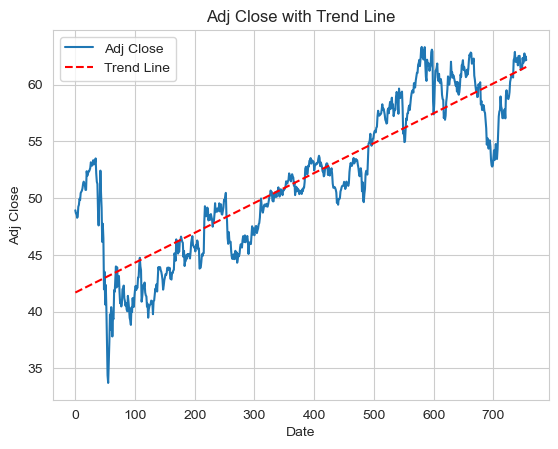

In [5]:
x = np.arange(len(df['Adj Close']))
poly_coeffs = np.polyfit(x, df['Adj Close'], deg=1)
poly_func = np.poly1d(poly_coeffs)

plt.plot(df['Adj Close'])
plt.plot(x, poly_func(x), color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('Adj Close with Trend Line')
plt.legend(['Adj Close', 'Trend Line'])
plt.grid(True)
plt.show()

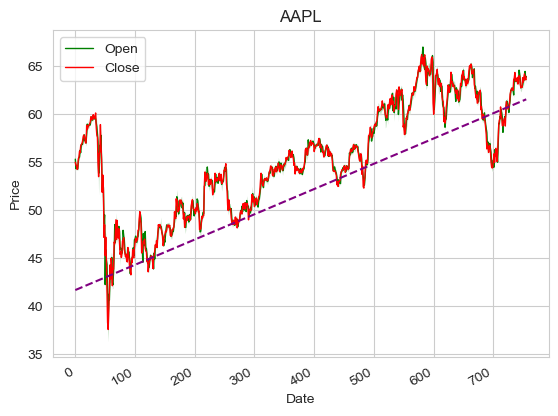

In [6]:
dates = df.index
open_values = df['Open']
close_values = df['Close']
high_values = df['High']
low_values = df['Low']

fig, ax = plt.subplots()

ax.plot(dates, open_values, 'g', linewidth=1, label='Open')
ax.plot(dates, close_values, 'r', linewidth=1, label='Close')
ax.fill_between(dates, low_values, high_values, facecolor='g', alpha=0.3)
plt.plot(x, poly_func(x), color='purple', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL')

fig.autofmt_xdate()
ax.legend()
plt.grid(True)
plt.show()

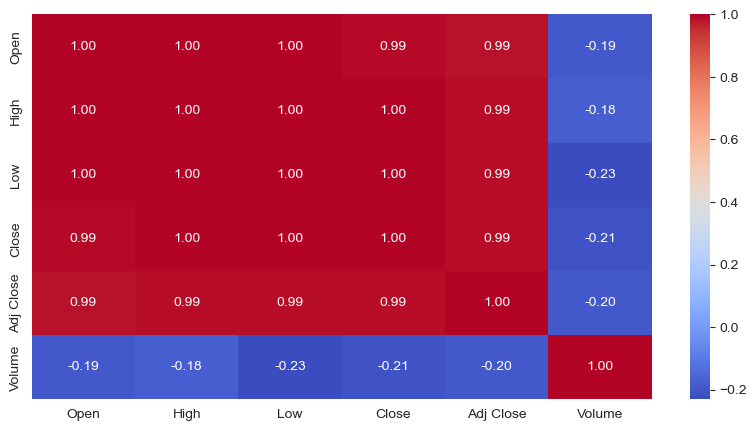

In [7]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

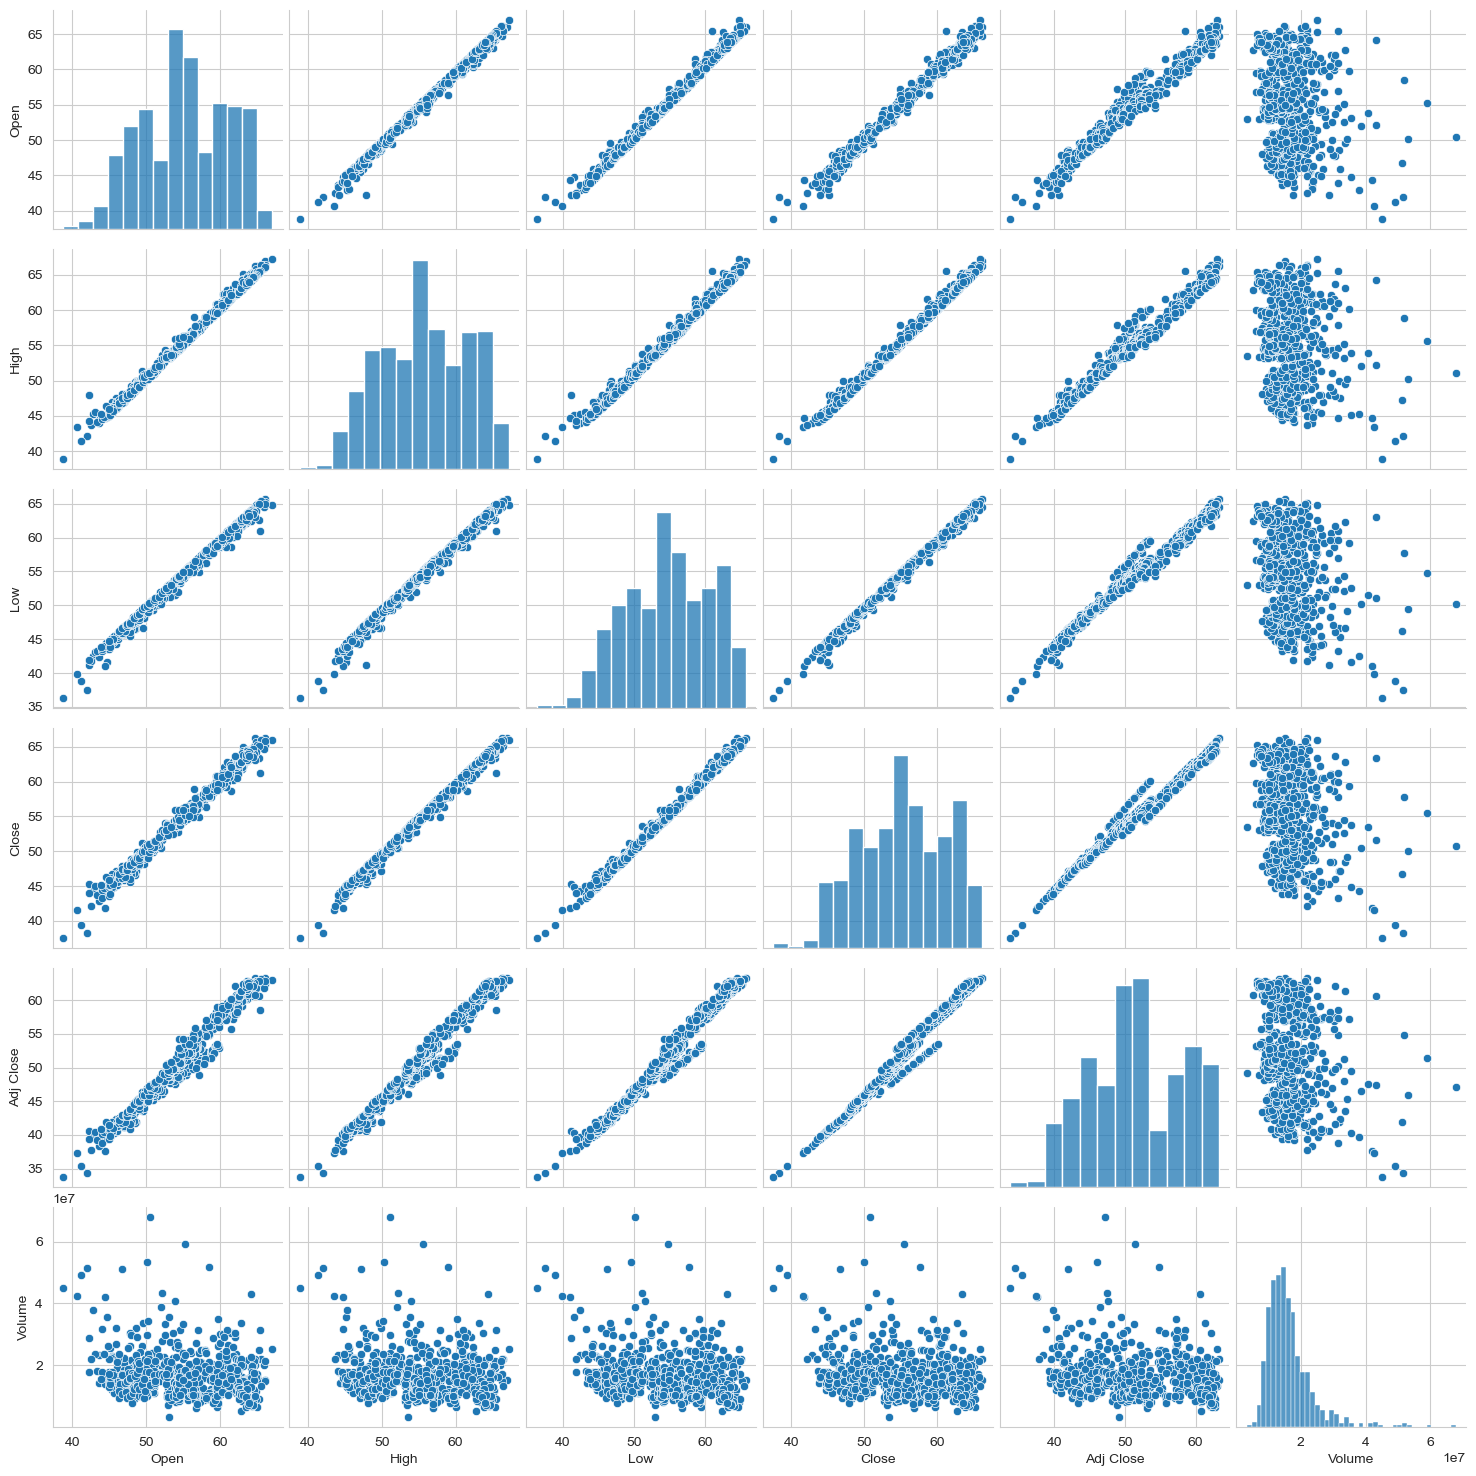

In [8]:
sns.pairplot(df)

In [9]:
final_df = df[['Date', 'Open']]
final_df = final_df.set_index('Date')
final_df.head()

,Open
Date,
2020-01-02,55.320000
2020-01-03,54.320000
2020-01-06,54.650002
2020-01-07,54.450001
2020-01-08,54.270000


In [8]:
X = df[['Open', 'High', 'Low', 'Close']]
y = df['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

In [9]:
print(f'r2: {r2}\n'
      f'MSE: {MSE}\n'
      f'MAE: {MAE}')

r2: 0.9997107245170282
MSE: 0.04703885609435979
MAE: 0.1853325118108588


In [10]:
final_df.index.is_monotonic

True

In [11]:
final_df.isna().sum()

Open    0
dtype: int64

In [12]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,756.0,55.240556,5.865178,38.759998,50.397501,55.109999,60.284999,67.0


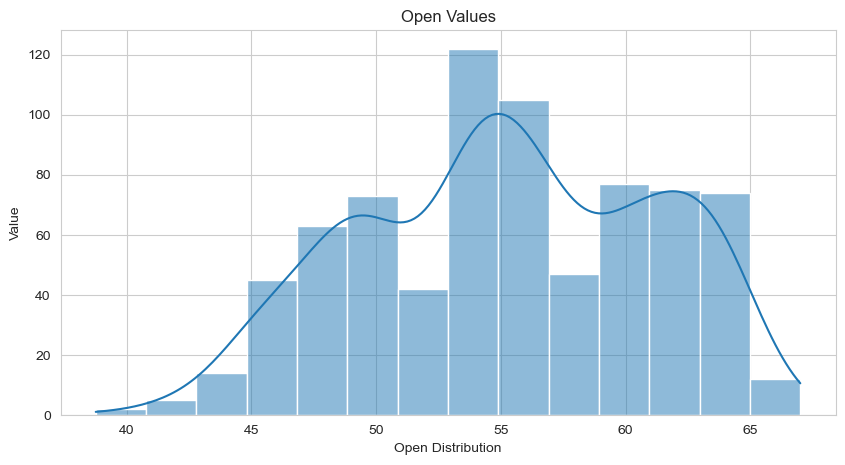

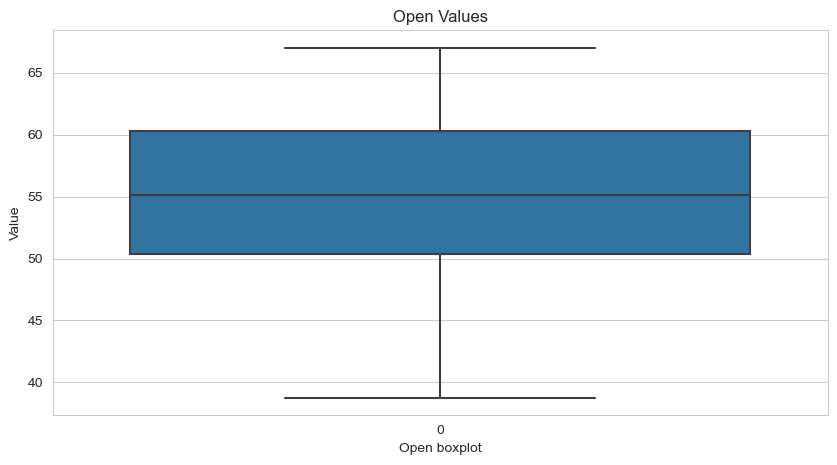

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(final_df['Open'], kde=True)
plt.xlabel('Open Distribution')
plt.ylabel('Value')
plt.title('Open Values')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(final_df['Open'])
plt.xlabel('Open boxplot')
plt.ylabel('Value')
plt.title('Open Values')
plt.show()

In [18]:
data = final_df.resample('1W').sum()
data.index.is_monotonic

True

In [19]:
data.isna().sum()

Open    0
dtype: int64

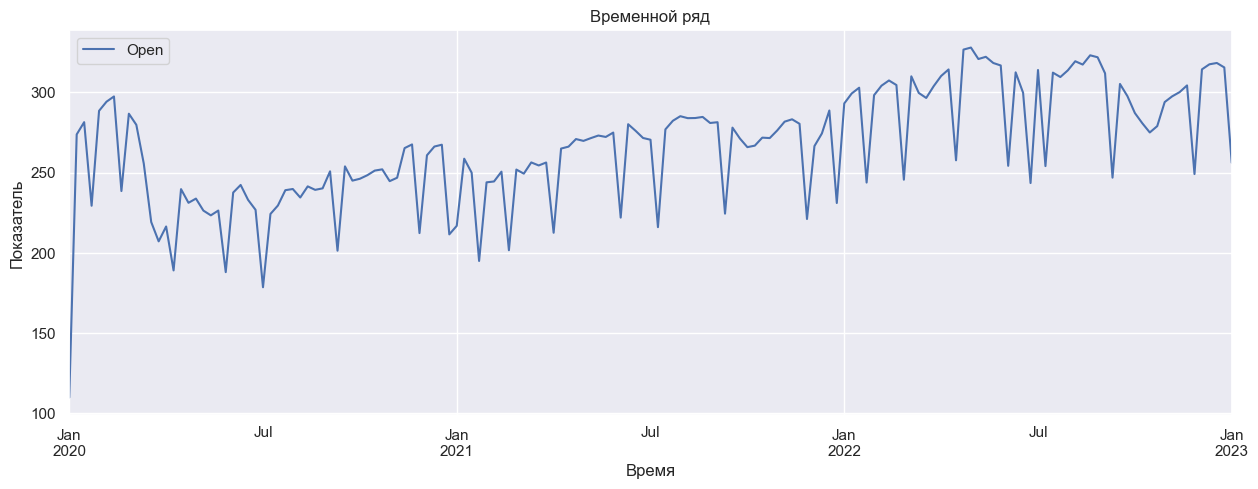

In [15]:
sns.set(rc={'figure.figsize':(15,5)})
data.plot()
plt.title('Временной ряд')
plt.xlabel('Время')
plt.ylabel('Показатель')
plt.show()

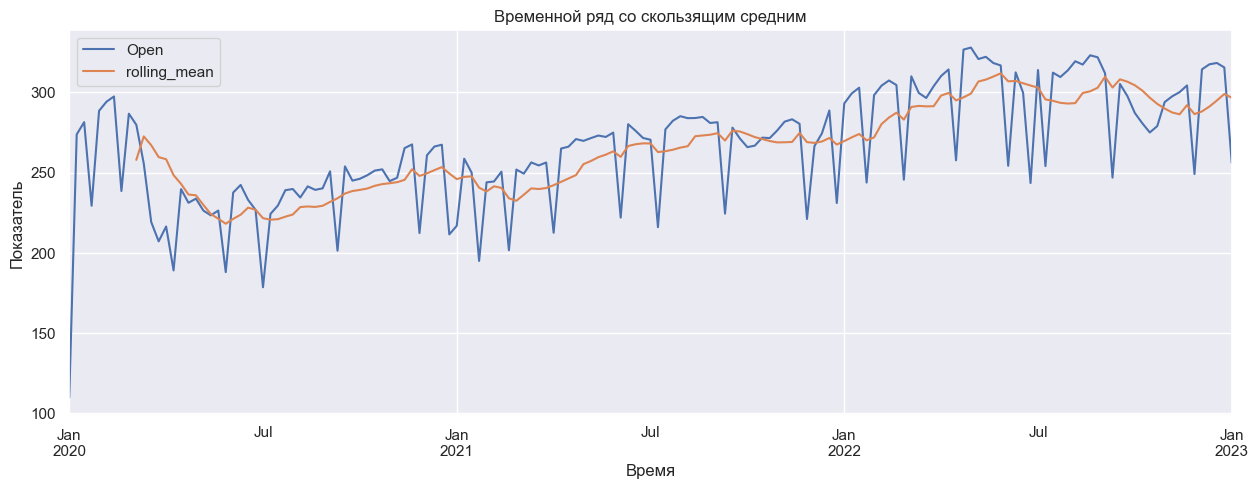

In [16]:
data['rolling_mean'] = data.rolling(10).mean()

sns.set(rc={'figure.figsize':(15,5)})
data.plot()
plt.title('Временной ряд со скользящим средним')
plt.xlabel('Время')
plt.ylabel('Показатель')
plt.show()

In [20]:
!pip install --upgrade statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 5.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [23]:
decomposed_df = seasonal_decompose(data)

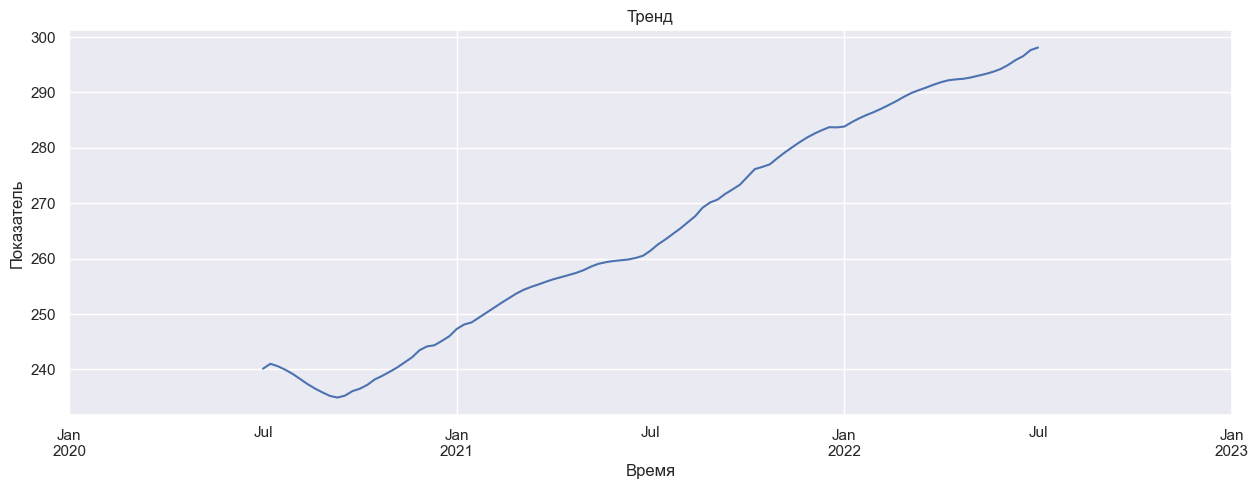

In [24]:
sns.set(rc={'figure.figsize':(15,5)})
decomposed_df.trend.plot()
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Показатель')
plt.show()

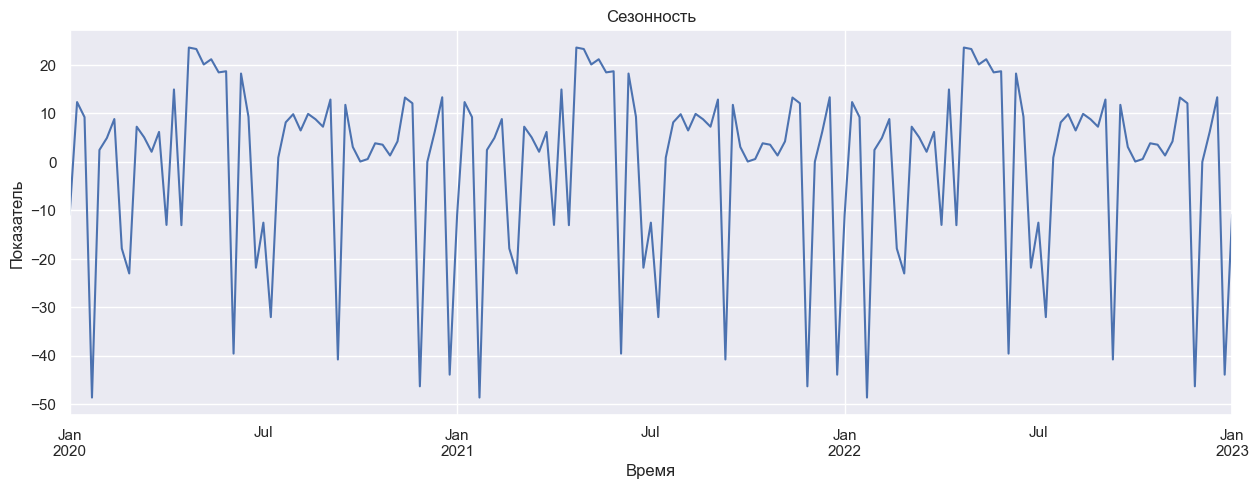

In [25]:
sns.set(rc={'figure.figsize':(15,5)})
decomposed_df.seasonal.plot()
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Показатель')
plt.show()

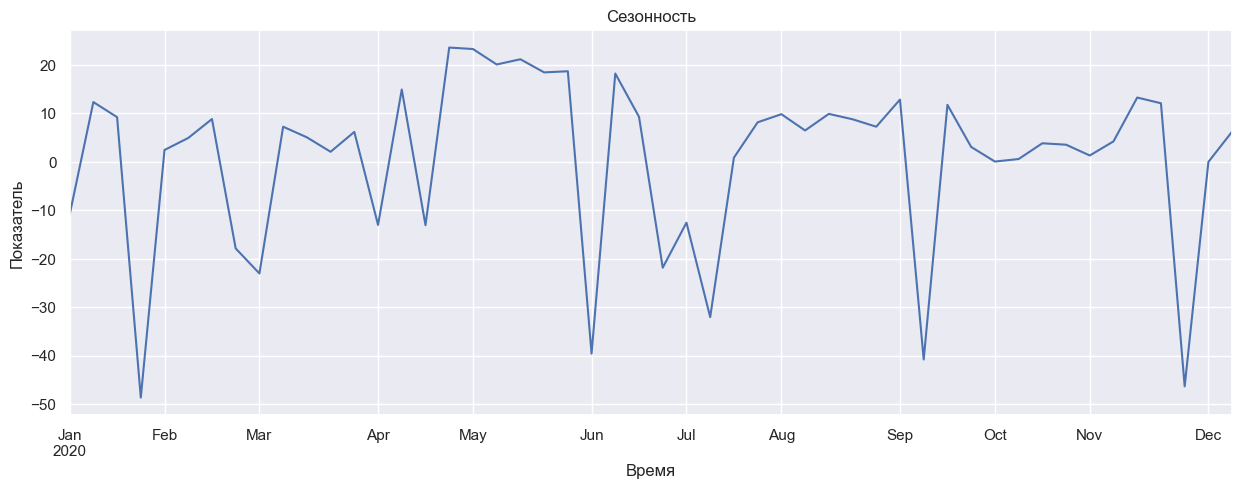

In [27]:
# Обрежем часть графика, чтобы он был читаемым
sns.set(rc={'figure.figsize':(15,5)})
decomposed_df.seasonal.head(50).plot()
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Показатель')
plt.show()

Примерно раз в квартал случаются просадки

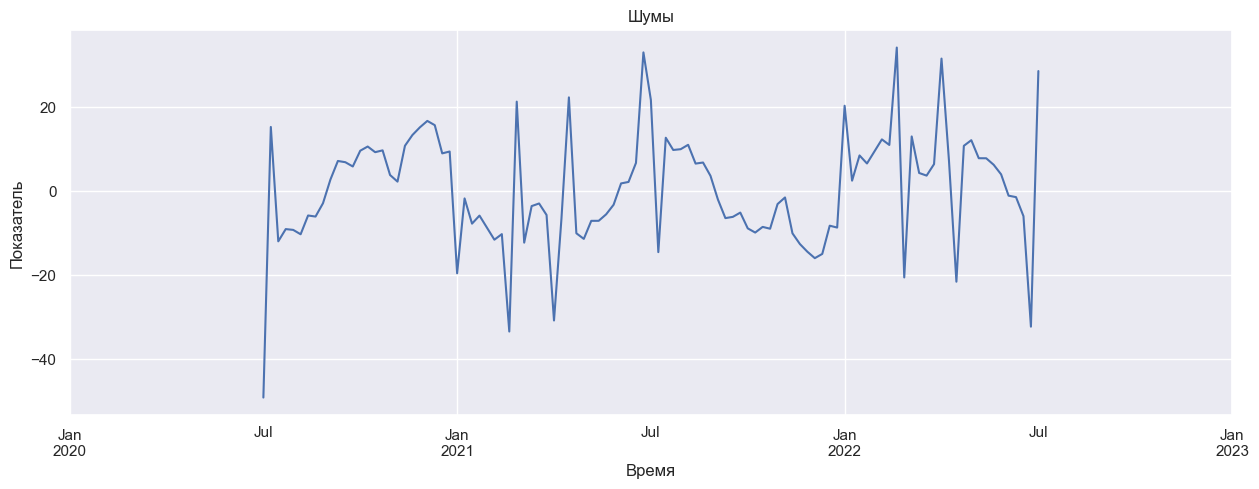

In [28]:
sns.set(rc={'figure.figsize':(15,5)})
decomposed_df.resid.head(300).plot()
plt.title('Шумы')
plt.xlabel('Время')
plt.ylabel('Показатель')
plt.show()

# 2 Preprocessing

In [32]:
def make_features(df, lag_size):
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    
    for i in range (1, lag_size + 1):
        df[f'lag_{i}'] = df['Open'].shift(i)
        
    df['rolling_mean'] = df['Open'].shift().rolling(1).mean()
    df.dropna(inplace=True)
    
    return df

In [33]:
final_df = make_features(final_df, 4)

In [34]:
final_df.head()

,Open,month,dayofweek,day,lag_1,lag_2,lag_3,lag_4,rolling_mean
Date,,,,,,,,,
2020-01-08,54.270000,1,2,8,54.450001,54.650002,54.320000,55.320000,54.450001
2020-01-09,55.000000,1,3,9,54.270000,54.450001,54.650002,54.320000,54.270000
2020-01-10,55.480000,1,4,10,55.000000,54.270000,54.450001,54.650002,55.000000
2020-01-13,55.529999,1,0,13,55.480000,55.000000,54.270000,54.450001,55.480000
2020-01-14,56.240002,1,1,14,55.529999,55.480000,55.000000,54.270000,55.529999


In [35]:
final_df.shape

(752, 9)

In [36]:
features = final_df.drop('Open', axis=1)
target = final_df['Open']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                          target,
                                          random_state=RS,
                                          test_size=0.25,
                                          shuffle=False)


for i in [X_train, X_test, y_train, y_test]:
    print(f'Shape: {i.shape}')

Shape: (564, 8)
Shape: (188, 8)
Shape: (564,)
Shape: (188,)


In [134]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [135]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=5)

# 3 Model Selection

## 3.1 Dummy Regressor

In [136]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_train)
dummy_cv = cross_val_score(dummy_model, 
                           X_train_scaled, 
                           y_train, 
                           cv=tscv,
                           scoring=mse)
dummy_mse = -np.mean(dummy_cv)
print(f'Dummy RMSE: {math.sqrt(dummy_mse)}')

Dummy RMSE: 4.968410256049149


## 3.2 Linear Regression

In [137]:
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)
reg_cv = cross_val_score(reg_model, 
                         X_train_scaled, 
                         y_train, 
                         cv=tscv,
                         scoring=mse)
reg_mse = -np.mean(reg_cv)
print(f'DuREgression RMSE: {math.sqrt(reg_mse)}')

DuREgression RMSE: 0.8965579974336675


## 3.3 Decision Tree

In [138]:
model_tree = DecisionTreeRegressor(random_state=RS, max_depth=20)

In [139]:
param_grid_tree = {
    'model_tree__max_depth': range(1, 20)
}

In [140]:
pipeline_tree = Pipeline([
    ('model_tree', model_tree)
])

In [141]:
%%time
grid_search_tree = GridSearchCV(pipeline_tree, param_grid_tree, cv=tscv, scoring=mse)
grid_search_tree.fit(X_train, y_train)

CPU times: user 446 ms, sys: 8.94 ms, total: 455 ms
Wall time: 454 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model_tree',
                                        DecisionTreeRegressor(max_depth=20,
                                                              random_state=42))]),
             param_grid={'model_tree__max_depth': range(1, 20)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [142]:
best_tree_model = grid_search_tree.best_estimator_
best_params_tree = grid_search_tree.best_params_

In [144]:
best_tree_model

Pipeline(steps=[('model_tree',
                 DecisionTreeRegressor(max_depth=4, random_state=42))])

In [145]:
best_params_tree

{'model_tree__max_depth': 4}

In [146]:
tree_pred = grid_search_tree.predict(X_test)
RMSE_tree = math.sqrt(mean_squared_error(y_test, tree_pred))
RMSE_tree

1.83523794462775

## 3.4 Random Forest

In [147]:
model_forest = RandomForestRegressor(random_state=RS,
                                     max_depth=20,
                                     n_estimators=20)

In [148]:
param_grid_forest = {
    'model_forest__max_depth': range(1, 20),
    'model_forest__n_estimators': range(1, 20)
}

In [149]:
pipeline_forest = Pipeline([
    ('model_forest', model_forest)
])

In [150]:
%%time
grid_search_forest = GridSearchCV(pipeline_forest, param_grid_forest, cv=tscv, scoring=mse)
grid_search_forest.fit(X_train, y_train)

CPU times: user 41.1 s, sys: 259 ms, total: 41.4 s
Wall time: 41.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model_forest',
                                        RandomForestRegressor(max_depth=20,
                                                              n_estimators=20,
                                                              random_state=42))]),
             param_grid={'model_forest__max_depth': range(1, 20),
                         'model_forest__n_estimators': range(1, 20)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [151]:
best_forest_model = grid_search_forest.best_estimator_
best_params_forest = grid_search_forest.best_params_

In [152]:
best_forest_model

Pipeline(steps=[('model_forest',
                 RandomForestRegressor(max_depth=15, n_estimators=12,
                                       random_state=42))])

In [153]:
best_params_forest

{'model_forest__max_depth': 15, 'model_forest__n_estimators': 12}

In [154]:
forest_pred = grid_search_forest.predict(X_test)
RMSE_forest = math.sqrt(mean_squared_error(y_test, forest_pred))
RMSE_forest

2.205308187530782

# 4 Testing

In [157]:
def graph(y_test, y_pred, index=y_test.index):
    dataframe = pd.DataFrame({
        'y_pred': y_pred,
        'y_test': y_test
    }, index=index)
    return dataframe.plot()

In [155]:
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)
reg_pred = reg_model.predict(X_test)
regmse = mean_squared_error(y_test, reg_pred)
print(f'Regression RMSE: {math.sqrt(regmse)}')

Regression RMSE: 286.8210084148436


In [156]:
model_tree_test = DecisionTreeRegressor(max_depth=4,
                                        random_state=42)
model_tree_test.fit(X_train, y_train)
y_pred_tree = model_tree_test.predict(X_test)
mse_tree_test = mean_squared_error(y_test, y_pred_tree)

print(f'Tree RMSE: {RMSE_tree}\n'
      f'Tree test RMSE: {math.sqrt(mse_tree_test)}')

Tree RMSE: 1.83523794462775
Tree test RMSE: 1.83523794462775


<Axes: xlabel='Date'>

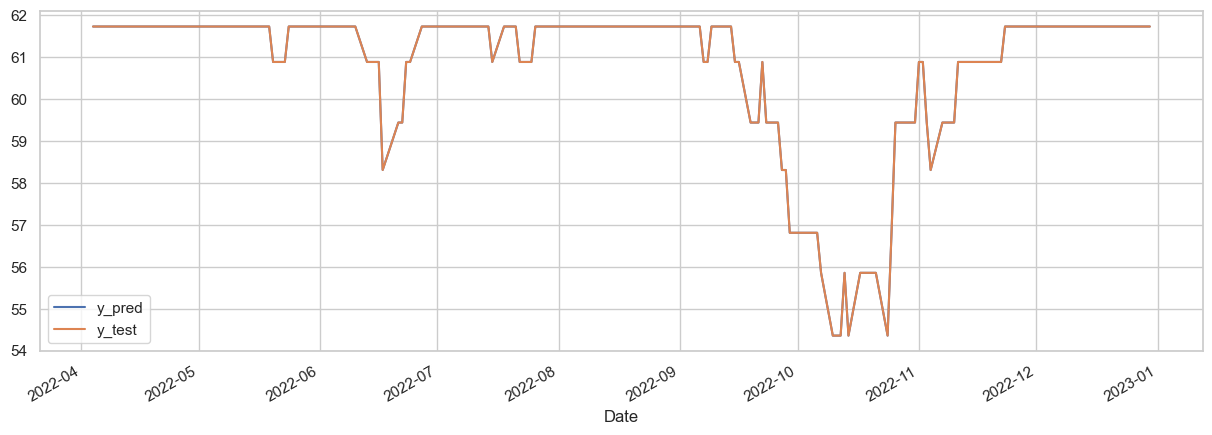

In [158]:
graph(y_pred_tree, tree_pred)